# Multimodal vector search - Video

In [1]:
APPLY = True
TABLE_NAME = 'docs'

<!-- TABS -->
## Connect to superduper

In [5]:
from superduper import superduper

db = superduper('mongomock://test_db')

2025-Mar-22 08:58:11.40| INFO     | Duncans-MacBook-Pro.local| superduper.misc.importing:13   | Loading plugin: mongodb
2025-Mar-22 08:58:11.40| INFO     | Duncans-MacBook-Pro.local| superduper.base.datalayer:51   | Building Data Layer
2025-Mar-22 08:58:11.40| INFO     | Duncans-MacBook-Pro.local| superduper.base.datalayer:68   | Data Layer built
2025-Mar-22 08:58:11.40| INFO     | Duncans-MacBook-Pro.local| superduper.backends.base.cluster:109  | Cluster initialized in 0.00 seconds.
2025-Mar-22 08:58:11.40| INFO     | Duncans-MacBook-Pro.local| superduper.base.build:148  | Configuration: 
 +----------------+-------------------------------+
| Configuration  |             Value             |
+----------------+-------------------------------+
|  Data Backend  |      mongomock://test_db      |
| Artifact Store | filesystem://./artifact_store |
|     Cache      |           in-process          |
+----------------+-------------------------------+


<!-- TABS -->
## Get useful sample data

In [6]:
def getter():
    import os
    import subprocess
    subprocess.run(['rm', 'videos.zip'])
    subprocess.run(['rm'
                    , '-rf', 'videos'])
    subprocess.run(['curl', '-O', 'https://superduperdb-public-demo.s3.amazonaws.com/videos.zip'])
    subprocess.run(['unzip', 'videos.zip'])
    subprocess.run(['rm', 'videos.zip'])
    data = [{'x': f'videos/{x}'} for x in os.listdir('./videos')]
    return data[:2]

In [7]:
if APPLY:
    data = getter()

rm: videos.zip: No such file or directory
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 92 20.2M   92 18.8M    0     0   794k      0  0:00:26  0:00:24  0:00:02 1312k

Archive:  videos.zip
   creating: videos/
  inflating: videos/4.mp4            
  inflating: videos/1.mp4            
  inflating: videos/2.mp4            
  inflating: videos/3.mp4            


100 20.2M  100 20.2M    0     0   833k      0  0:00:24  0:00:24 --:--:-- 1568k


<!-- TABS -->
## Create datatype

SuperduperDB supports automatic data conversion, so users don’t need to worry about the compatibility of different data formats (`PIL.Image`, `numpy.array`, `pandas.DataFrame`, etc.) with the database.

It also supports custom data conversion methods for transforming data, such as defining the following Datatype.

<!-- TABS -->
## Setup tables or collections

In [8]:
from superduper.components.table import Table
from superduper import Schema

table = Table(TABLE_NAME, fields={'x': 'file'})

if APPLY:
    db.apply(table, force=True)

2025-Mar-22 08:58:46.61| INFO     | Duncans-MacBook-Pro.local| superduper.base.datalayer:388  | Load (('Table', 'docs')) from metadata...
2025-Mar-22 08:58:46.62| INFO     | Duncans-MacBook-Pro.local| superduper.base.apply:94   | Found these changes and/ or additions that need to be made:
2025-Mar-22 08:58:46.62| INFO     | Duncans-MacBook-Pro.local| superduper.base.apply:96   | ----------------------------------------------------------------------------------------------------
2025-Mar-22 08:58:46.62| INFO     | Duncans-MacBook-Pro.local| superduper.base.apply:97   | METADATA EVENTS:
2025-Mar-22 08:58:46.62| INFO     | Duncans-MacBook-Pro.local| superduper.base.apply:98   | ----------------------------------------------------------------------------------------------------
2025-Mar-22 08:58:46.62| INFO     | Duncans-MacBook-Pro.local| superduper.base.apply:109  | [0]: Table:docs:9d5ece60e98371942224b00c3e86aa35: create
2025-Mar-22 08:58:46.62| INFO     | Duncans-MacBook-Pro.local| sup

In [9]:
if APPLY:
    db[TABLE_NAME].insert(data)

2025-Mar-22 08:58:49.21| INFO     | Duncans-MacBook-Pro.local| superduper.base.datalayer:388  | Load (('Table', 'docs')) from metadata...
2025-Mar-22 08:58:49.21| INFO     | Duncans-MacBook-Pro.local| superduper.base.artifacts:273  | Copying file videos/4.mp4 to ./artifact_store/c97d156b28006f21ebaa4a13e38a77e9bbf8c6ef01fc2af850a0447564cdd663/4.mp4
2025-Mar-22 08:58:49.21| INFO     | Duncans-MacBook-Pro.local| superduper.base.artifacts:273  | Copying file videos/1.mp4 to ./artifact_store/abf2b1fa3a46e77af826ca67ba3de744c26ac5ae1d280f612e280ffc0517463f/1.mp4


<!-- TABS -->
## Apply a chunker for search

:::note
Note that applying a chunker is ***not*** mandatory for search.
If your data is already chunked (e.g. short text snippets or audio) or if you
are searching through something like images, which can't be chunked, then this
won't be necessary.
:::

In [ ]:
!pip install opencv-python

In [10]:
import cv2
import tqdm
from PIL import Image
from superduper import Schema, ObjectModel
from superduper.base.datatype import FileItem
from superduper.misc.importing import isreallyinstance


def chunker(video_file):
    # Set the sampling frequency for frames

    if isreallyinstance(video_file, FileItem):
        video_file = video_file.unpack()
    sample_freq = 100
    
    # Open the video file using OpenCV
    cap = cv2.VideoCapture(video_file)
    
    # Initialize variables
    frame_count = 0
    fps = cap.get(cv2.CAP_PROP_FPS)
    extracted_frames = []
    progress = tqdm.tqdm()

    # Iterate through video frames
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Get the current timestamp based on frame count and FPS
        current_timestamp = frame_count // fps
        
        # Sample frames based on the specified frequency
        if frame_count % sample_freq == 0:
            extracted_frames.append({
                'image': Image.fromarray(frame[:,:,::-1]),  # Convert BGR to RGB
                'current_timestamp': current_timestamp,
            })
        frame_count += 1
        progress.update(1)
    
    # Release resources 
    cap.release()
    cv2.destroyAllWindows()
    
    # Return the list of extracted frames
    return extracted_frames


chunker = ObjectModel(
    'chunker', 
    object=chunker,
    datatype='image=superduper_pillow.pil_image|current_timestamp=int',
)

Now we apply this chunker to the data by wrapping the chunker in `Listener`:

In [11]:
from superduper import Listener

upstream_listener = Listener(
    model=chunker,
    select=db['docs'],
    key='x',
    identifier='chunker',
    flatten=True,
    upstream=[table],
)

In [ ]:
db.remove('Listener', 'chunker', force=True)

In [12]:
if APPLY:
    db.apply(upstream_listener, force=True)

2025-Mar-22 08:58:56.66| INFO     | Duncans-MacBook-Pro.local| superduper.base.datalayer:388  | Load (('Listener', 'chunker')) from metadata...
2025-Mar-22 08:58:56.66| INFO     | Duncans-MacBook-Pro.local| superduper.base.datalayer:388  | Load (('Table', 'docs')) from metadata...
2025-Mar-22 08:58:56.67| INFO     | Duncans-MacBook-Pro.local| superduper.base.datalayer:388  | Load (('ObjectModel', 'chunker')) from metadata...
2025-Mar-22 08:58:56.67| WARNING  | Duncans-MacBook-Pro.local| superduper.base.artifacts:243  | File ./artifact_store/41c0027e7f65171a3f3b7d915a4d1e9391e96f279ab55ddc1ccd958651d82c3a already exists
2025-Mar-22 08:58:56.68| INFO     | Duncans-MacBook-Pro.local| superduper.base.datalayer:388  | Load (('Table', '_outputs__chunker__2fbc8c25e30d3c08e0c29b79c858ad05')) from metadata...
2025-Mar-22 08:58:56.69| INFO     | Duncans-MacBook-Pro.local| superduper.base.apply:94   | Found these changes and/ or additions that need to be made:
2025-Mar-22 08:58:56.69| INFO     | 

4491it [00:00, 12011.04it/s]
900it [00:00, 4643.70it/s]


2025-Mar-22 08:58:57.31| INFO     | Duncans-MacBook-Pro.local| superduper.base.datalayer:388  | Load (('Table', '_outputs__chunker__2fbc8c25e30d3c08e0c29b79c858ad05')) from metadata...
2025-Mar-22 08:58:57.55| INFO     | Duncans-MacBook-Pro.local| superduper.base.datalayer:388  | Load (('Table', 'Job')) from metadata...


# Build multimodal embedding models

We define the output data type of a model as a vector for vector transformation.

Then define two models, one for text embedding and one for image embedding.

In [74]:
import clip
import torch

from superduper import Model


class TextModel(Model):
    model: str = 'Vit-B/32'
    device: str = 'cpu'
    
    def init(self):
        self.vit = clip.load("ViT-B/32", device='cpu')[0]
        self.vit.to(self.device)

    def predict(self, text):
        preprocessed = clip.tokenize(text)
        activations = self.vit.encode_text(preprocessed)[0]
        return activations.detach().numpy()


class ImageModel(Model):
    model: str = 'Vit-B/32'
    device: str = 'cpu'
    batch_size: int = 10

    def init(self):
        tmp = clip.load("ViT-B/32", device='cpu')
        self.visual_model = tmp[0].visual
        self.preprocess = tmp[1]

    def predict(self, image):
        preprocessed = self.preprocess(image)[None, :]
        activations = self.visual_model(preprocessed)[0]
        return activations.detach().numpy()

    def predict_batches(self, images):
        out = []
        for i in range(0, len(images), self.batch_size):
            sub = images[i: i + self.batch_size]
            preprocessed = [self.preprocess(img) for img in sub]
            activations = self.visual_model(torch.stack(preprocessed, 0))
            out.extend([x.detach().numpy() for x in activations])
        return out

In [87]:
text_model = TextModel('text', datatype='vector[float:512]')
image_model = ImageModel('image', datatype='vector[float:512]')

Because we use multimodal models, we define different keys to specify which model to use for embedding calculations in the vector_index.

## Create vector-index

In [88]:
from superduper import VectorIndex, Listener

vector_index = VectorIndex(
    'my-vector-index',
    indexing_listener=Listener(
        key=upstream_listener.outputs + '.image',
        select=db[upstream_listener.outputs].select(),
        model=image_model,
        identifier=f'{text_model.identifier}-listener'
    ),
    compatible_listener=Listener(
        key='text',
        model=text_model,
        select=None,
        identifier='compatible-listener',
    ),
    upstream=[upstream_listener],
)

In [89]:
if APPLY:
    db.apply(vector_index)

2025-Mar-22 12:41:04.12| INFO     | Duncans-MacBook-Pro.local| superduper.base.datalayer:388  | Load (('VectorIndex', 'my-vector-index')) from metadata...
2025-Mar-22 12:41:04.13| INFO     | Duncans-MacBook-Pro.local| superduper.base.datalayer:388  | Load (('Listener', 'chunker')) from metadata...
2025-Mar-22 12:41:04.14| INFO     | Duncans-MacBook-Pro.local| superduper.base.datalayer:388  | Load (('Table', 'docs')) from metadata...
2025-Mar-22 12:41:04.14| INFO     | Duncans-MacBook-Pro.local| superduper.base.datalayer:388  | Load (('ObjectModel', 'chunker')) from metadata...
2025-Mar-22 12:41:04.14| WARNING  | Duncans-MacBook-Pro.local| superduper.base.artifacts:243  | File ./artifact_store/41c0027e7f65171a3f3b7d915a4d1e9391e96f279ab55ddc1ccd958651d82c3a already exists
2025-Mar-22 12:41:04.14| INFO     | Duncans-MacBook-Pro.local| superduper.base.datalayer:388  | Load (('Table', '_outputs__chunker__2fbc8c25e30d3c08e0c29b79c858ad05')) from metadata...
2025-Mar-22 12:41:04.15| INFO    

my-vector-index
├── my-vector-index
│   └── status: breaking
├── text-listener
│   └── status: breaking
├── image
│   └── status: update
└── compatible-listener
    └── status: breaking

2025-Mar-22 12:41:04.17| INFO     | Duncans-MacBook-Pro.local| superduper.base.apply:94   | Found these changes and/ or additions that need to be made:
2025-Mar-22 12:41:04.17| INFO     | Duncans-MacBook-Pro.local| superduper.base.apply:96   | ----------------------------------------------------------------------------------------------------
2025-Mar-22 12:41:04.17| INFO     | Duncans-MacBook-Pro.local| superduper.base.apply:97   | METADATA EVENTS:
2025-Mar-22 12:41:04.17| INFO     | Duncans-MacBook-Pro.local| superduper.base.apply:98   | ----------------------------------------------------------------------------------------------------
2025-Mar-22 12:41:04.17| INFO     | Duncans-MacBook-Pro.local| superduper.base.apply:105  | [0]: ImageModelimage:2db0449742d85291cdf65c73eb238dc7: update ~ [2]
2025-Mar-22 12:41:04.17| INFO     | Duncans-MacBook-Pro.local| superduper.base.apply:105  | [1]: Table:_outputs__text-listener__88a82bc75a20ee7c962b39fcda7f36bd:8bde8cf0c71bd4de3fc63571dc0cb59a

2025-Mar-22 12:41:06.00| INFO     | Duncans-MacBook-Pro.local| superduper.base.event:142  | Creating superduper.components.table.Table:_outputs__text-listener__88a82bc75a20ee7c962b39fcda7f36bd:8bde8cf0c71bd4de3fc63571dc0cb59a
2025-Mar-22 12:41:06.00| INFO     | Duncans-MacBook-Pro.local| superduper.base.datalayer:388  | Load (('Table', 'Table')) from metadata...
2025-Mar-22 12:41:06.01| INFO     | Duncans-MacBook-Pro.local| superduper.base.datalayer:388  | Load (('Table', 'ParentChildAssociations')) from metadata...
2025-Mar-22 12:41:06.02| INFO     | Duncans-MacBook-Pro.local| superduper.base.event:142  | Creating superduper.components.listener.Listener:text-listener:88a82bc75a20ee7c962b39fcda7f36bd
2025-Mar-22 12:41:06.02| INFO     | Duncans-MacBook-Pro.local| superduper.base.datalayer:388  | Load (('Table', 'Listener')) from metadata...
2025-Mar-22 12:41:06.03| INFO     | Duncans-MacBook-Pro.local| superduper.base.datalayer:388  | Load (('Table', 'ParentChildAssociations')) from met

In [90]:
db.show()

[{'component': 'ImageModel', 'identifier': 'image'},
 {'component': 'Listener', 'identifier': 'chunker'},
 {'component': 'Listener', 'identifier': 'compatible-listener'},
 {'component': 'Listener', 'identifier': 'text-listener'},
 {'component': 'ObjectModel', 'identifier': 'chunker'},
 {'component': 'Table', 'identifier': 'ImageModel'},
 {'component': 'Table', 'identifier': 'Listener'},
 {'component': 'Table', 'identifier': 'ObjectModel'},
 {'component': 'Table', 'identifier': 'TextModel'},
 {'component': 'Table', 'identifier': 'VectorIndex'},
 {'component': 'Table',
  'identifier': '_outputs__chunker__2fbc8c25e30d3c08e0c29b79c858ad05'},
 {'component': 'Table',
  'identifier': '_outputs__compatible-listener__c926764254f2eeb483990ef1091b555e'},
 {'component': 'Table',
  'identifier': '_outputs__compatible-listener__ed0ad736ed88ab60e26b5fd224610809'},
 {'component': 'Table',
  'identifier': '_outputs__text-listener__0491a61d20c24a4f08f861d06bf00cdb'},
 {'component': 'Table',
  'identifie

In [91]:
from superduper import Application

app = Application(
    'video-search',
    components=[
        upstream_listener,
        vector_index,
    ]
)

In [92]:
if APPLY:
    db.apply(app)

2025-Mar-22 12:43:02.70| INFO     | Duncans-MacBook-Pro.local| superduper.base.datalayer:388  | Load (('Application', 'video-search')) from metadata...
2025-Mar-22 12:43:02.71| INFO     | Duncans-MacBook-Pro.local| superduper.base.datalayer:388  | Load (('Listener', 'chunker')) from metadata...
2025-Mar-22 12:43:02.71| INFO     | Duncans-MacBook-Pro.local| superduper.base.datalayer:388  | Load (('Table', 'docs')) from metadata...
2025-Mar-22 12:43:02.72| INFO     | Duncans-MacBook-Pro.local| superduper.base.datalayer:388  | Load (('ObjectModel', 'chunker')) from metadata...
2025-Mar-22 12:43:02.72| WARNING  | Duncans-MacBook-Pro.local| superduper.base.artifacts:243  | File ./artifact_store/41c0027e7f65171a3f3b7d915a4d1e9391e96f279ab55ddc1ccd958651d82c3a already exists
2025-Mar-22 12:43:02.72| INFO     | Duncans-MacBook-Pro.local| superduper.base.datalayer:388  | Load (('Table', '_outputs__chunker__2fbc8c25e30d3c08e0c29b79c858ad05')) from metadata...
2025-Mar-22 12:43:02.73| INFO     | 

2025-Mar-22 12:43:03.63| INFO     | Duncans-MacBook-Pro.local| superduper.base.event:142  | Creating superduper.components.application.Application:video-search:846d5f6dbc6cc8c01bea9d6da6a030b7
2025-Mar-22 12:43:03.64| INFO     | Duncans-MacBook-Pro.local| superduper.base.datalayer:388  | Load (('Table', 'Table')) from metadata...
2025-Mar-22 12:43:03.65| INFO     | Duncans-MacBook-Pro.local| superduper.base.datalayer:388  | Load (('Table', 'Application')) from metadata...
2025-Mar-22 12:43:03.67| WARNING  | Duncans-MacBook-Pro.local| superduper.backends.local.compute:39   | Could not release futures for context 846d5f6dbc6cc8c01bea9d6da6a030b7


## Perform a vector search

We can perform the vector searches using text description:

In [109]:
from superduper import Document
query = "Monkeys playing"

In [94]:
from superduper import Document
query = "Spaceship on the moon"

Once we have this search target, we can execute a search as follows.

## Visualize Results

2025-Mar-22 13:02:17.98| INFO     | Duncans-MacBook-Pro.local| superduper.base.datalayer:601  | Getting vector-index
2025-Mar-22 13:02:17.98| INFO     | Duncans-MacBook-Pro.local| superduper.base.datalayer:388  | Load (('VectorIndex', 'my-vector-index')) from metadata...
2025-Mar-22 13:02:17.99| INFO     | Duncans-MacBook-Pro.local| superduper.base.datalayer:609  | {}
2025-Mar-22 13:02:19.39| INFO     | Duncans-MacBook-Pro.local| superduper.base.datalayer:388  | Load (('VectorIndex', 'my-vector-index')) from metadata...


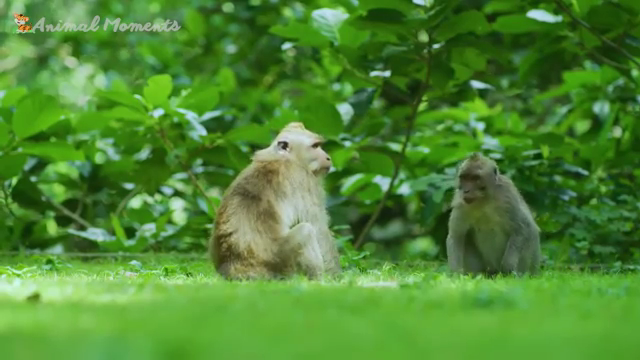

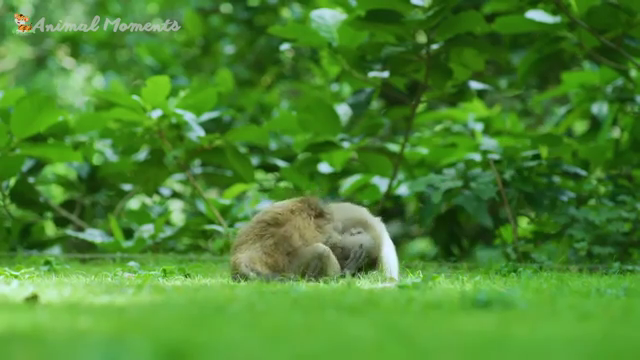

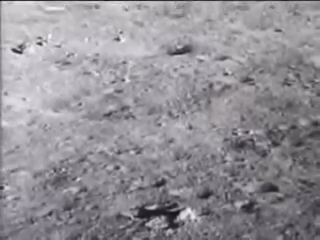

In [111]:
if APPLY:
    from IPython.display import display
    select = db[upstream_listener.outputs].like({'text': query}, vector_index='my-vector-index', n=3).select()

    for result in select.execute():
        display(result[upstream_listener.outputs + '.image'])

In [ ]:
from superduper import Template, Table, Schema
from superduper.components.dataset import RemoteData

t = Template(
    'multimodal_video_search', 
    template=app,
    substitutions={'docs': 'table_name'},
    default_tables=[Table(
        'sample_multimodal_video_search',
        schema=Schema(
            'sample_multimodal_video_search/schema',
            fields={'x': 'file'},
        ),
        data=RemoteData(
            'sample_videos',
            getter=getter,
        )
    )],
    types={
        'table_name': {
            'type': 'str',
            'default': 'sample_multimodal_video_search',
        }
    },
    db=db,
)

In [ ]:
t.export('.')